In this tutorial, we will introduce the following content: <br>
1. Prepare demo data<br>
2. Prepare the settings<br>
3. Train and test model<br>
4. Export onnx<br>

If you want to inference pretrained model only, you can refer to <br>
 Inference PreTrained.ipynb <br>

In [1]:
%cd detectron2

/home/test/carasml/detection/d2_FasterRCNN/detectron2


/home/test/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Download a demo dataset

In [2]:
# package fiftyone is an open-source tool designed to help you work with datasets, offering free images and annotations

In [2]:
import fiftyone.zoo as foz

# here we choose detection and segmentation as our task, and set cute tortoises and lizards which like hiding as the objects to find
foz.load_zoo_dataset(
    "open-images-v7",
    split="train",
    label_types=["detections"],
    classes = ["Tortoise", "Lizard"],
)

foz.load_zoo_dataset(
    "open-images-v7",
    split="validation",
    label_types=["detections"],
    classes = ["Tortoise", "Lizard"],
)

!mv ~/fiftyone dataset

# you may try other approach to download the dataset at https://storage.googleapis.com/openimages/web/download_v7.html, in case the above code fails

 100% |██████|    4.8Gb/4.8Gb [22.2s elapsed, 0s remaining, 214.8Mb/s]      
 100% |█████████████████| 3157/3157 [28.4s elapsed, 0s remaining, 8.1 files/s]        
Dataset info written to '/home/test/fiftyone/open-images-v7/info.json'
Loading existing dataset 'open-images-v7-train'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
 100% |███████████████████| 143/143 [6.1s elapsed, 0s remaining, 22.9 files/s]       
Dataset info written to '/home/test/fiftyone/open-images-v7/info.json'
Loading existing dataset 'open-images-v7-validation'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [2]:
# write a function that loads the dataset into detectron2's standard format
# if your dataset is not in the same format, you need to revise the code of this part
import os
import pandas as pd
import cv2
from detectron2.structures import BoxMode
from detectron2.data import MetadataCatalog, DatasetCatalog

def get_dataset_dicts(path):
    classes = ["Tortoise", "Lizard"]
    image_path = os.path.join(path, "data/")
    image_list = [f for f in os.listdir(image_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    #load the class id
    class_path = os.path.join(path, "metadata/classes.csv")
    #load the labels 
    label_path = os.path.join(path, "labels/detections.csv")
    
    class_df = pd.read_csv(class_path, header=None)
    label_df = pd.read_csv(label_path)
    #find the id of our tortoise and lizard in the csv
    def get_code_by_name(df, name_list):
        return [df.loc[df.loc[:,1] == val, 0].values[0] for val in name_list]
    class_id = get_code_by_name(class_df, classes)
    image_list_no_ext = [img.split('.')[0] for img in image_list]
    label_df = label_df[label_df["ImageID"].isin(image_list_no_ext)]
    label_df = label_df[label_df["LabelName"].isin(class_id)]

    dataset_dicts = []
    for idx, (i, j) in enumerate(zip(image_list, image_list_no_ext)):  # Added enumerate for sequential IDs
        record = {}
        filename = os.path.join(image_path, i)
        height, width = cv2.imread(filename).shape[:2]
    
        record["file_name"] = filename
        record["height"] = height
        record["width"] = width
        record["image_id"] = idx  # Changed to sequential integer starting from 0
    
        sub_label_df = label_df[label_df["ImageID"]==j]
        objs = []
        #convert box relative position to absolute position (by pixel)
        for index, row in sub_label_df.iterrows():
            obj = {
              'bbox': [int(row['XMin']*width), int(row['YMin']*height), int(row['XMax']*width), int(row['YMax']*height)],
              'bbox_mode': BoxMode.XYXY_ABS,
              'category_id': class_id.index(row['LabelName']),
              "iscrowd": 0}
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [3]:
# register the dataset
for d in ["train","validation"]: 
    DatasetCatalog.register("turnliz_" + d, lambda d=d: get_dataset_dicts("dataset/fiftyone/open-images-v7/"+ d+"/"))
    MetadataCatalog.get("turnliz_" + d).set(thing_classes=["Tortoise", "Lizard"])
turnliz_metadata = MetadataCatalog.get("turnliz_train")

In [4]:
turnliz_metadata

namespace(name='turnliz_train', thing_classes=['Tortoise', 'Lizard'])

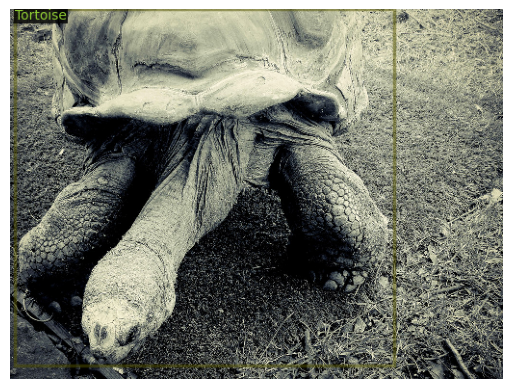

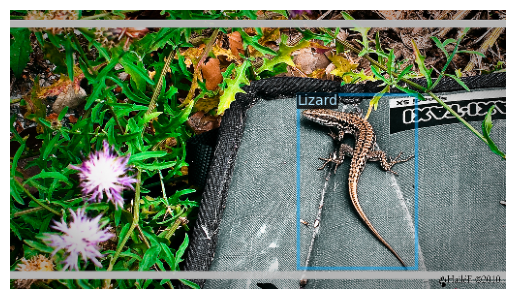

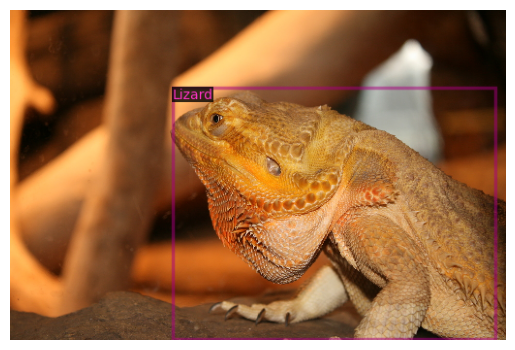

In [5]:
# lets see some samples of the dataset
import random
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
dataset_dicts = get_dataset_dicts("dataset/fiftyone/open-images-v7/train/")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=turnliz_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    #cv2_imshow(out.get_image()[:, :, ::-1])
    im = cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct colors
    plt.imshow(im)
    plt.axis("off")  # Hide axes
    plt.show()

# Train our model

There are plenty of models available, you can go to <br>
detectron2/detectron2/model_zoo/configs/ <br>
to choose a model <br>
name "my_yaml" as the location of the yaml  <br>
Check <br>
https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md <br>
for details of models

In [8]:
# e.g.
my_yaml = "COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"

In [9]:
# start training !!
# you may revise the configs to meet your custom needs
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(my_yaml))
cfg.DATASETS.TRAIN = ('turnliz_train',)
cfg.DATASETS.TEST = ()   # no metrics implemented
cfg.DATALOADER.NUM_WORKERS = 8
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(my_yaml)
cfg.SOLVER.IMS_PER_BATCH = 4  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR, if you have no idea, start with the default divided by 8
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # 2 classes. (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[06/02 11:19:01 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f6e8b1.pkl: 243MB [00:07, 33.7MB/s]                              
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_

[06/02 11:19:29 d2.engine.train_loop]: Starting training from iteration 0


/home/z890/.conda/envs/d2_FasterRCNN/lib/python3.10/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/02 11:19:33 d2.utils.events]:  eta: 0:02:36  iter: 19  total_loss: 1.567  loss_cls: 0.9826  loss_box_reg: 0.5476  loss_rpn_cls: 0.009094  loss_rpn_loc: 0.009046    time: 0.1597  last_time: 0.1380  data_time: 0.0160  last_data_time: 0.0052   lr: 4.9953e-06  max_mem: 6468M
[06/02 11:19:36 d2.utils.events]:  eta: 0:02:29  iter: 39  total_loss: 1.448  loss_cls: 0.8964  loss_box_reg: 0.5121  loss_rpn_cls: 0.005894  loss_rpn_loc: 0.007881    time: 0.1553  last_time: 0.1450  data_time: 0.0043  last_data_time: 0.0027   lr: 9.9902e-06  max_mem: 6691M
[06/02 11:19:39 d2.utils.events]:  eta: 0:02:26  iter: 59  total_loss: 1.248  loss_cls: 0.7497  loss_box_reg: 0.4908  loss_rpn_cls: 0.005011  loss_rpn_loc: 0.00825    time: 0.1549  last_time: 0.1325  data_time: 0.0048  last_data_time: 0.0046   lr: 1.4985e-05  max_mem: 6691M
[06/02 11:19:42 d2.utils.events]:  eta: 0:02:22  iter: 79  total_loss: 1.164  loss_cls: 0.6127  loss_box_reg: 0.5105  loss_rpn_cls: 0.008699  loss_rpn_loc: 0.00984    time: 

In [10]:
# see how the trained model performs on validation images
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)
print(f'Config:\n{cfg}')

[06/02 11:22:48 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
Config:
CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 8
  REPEAT_SQRT: True
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ()
  TRAIN: ('turnliz_train',)
FLOAT32_PRECISION: 
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128

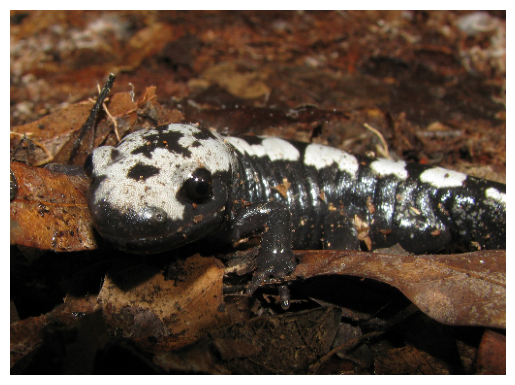

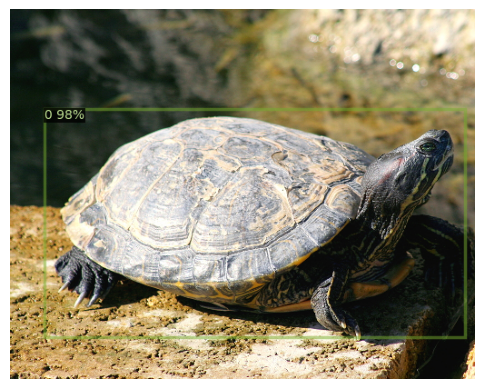

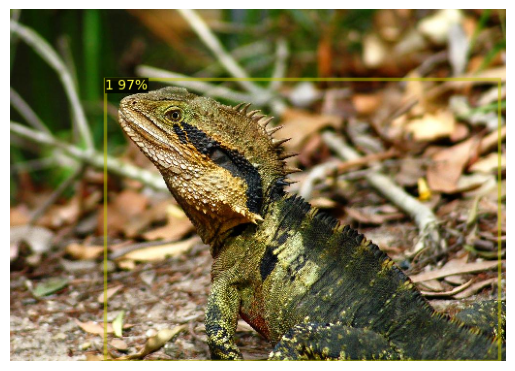

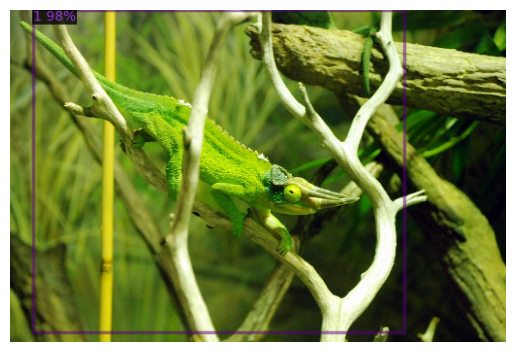

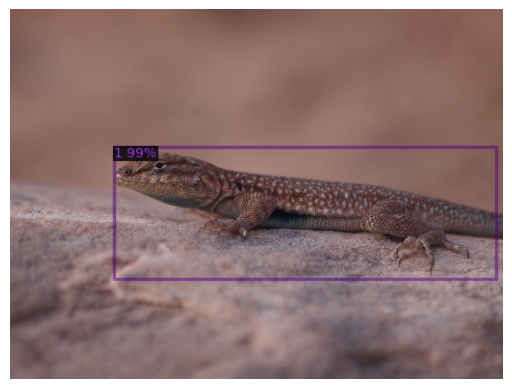

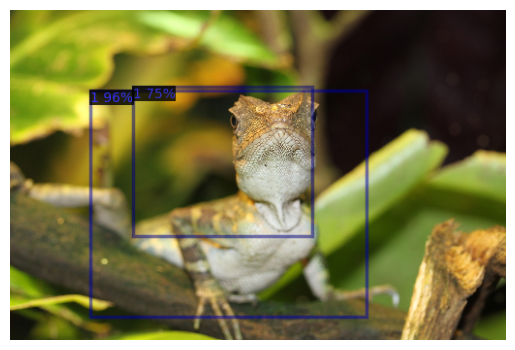

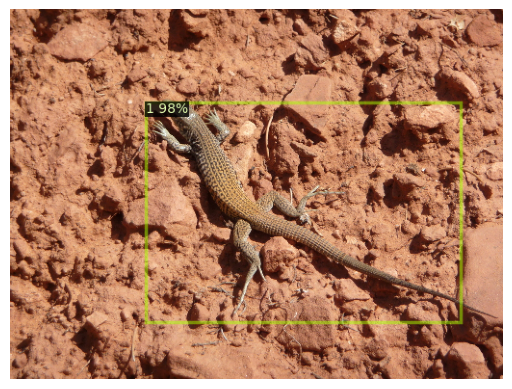

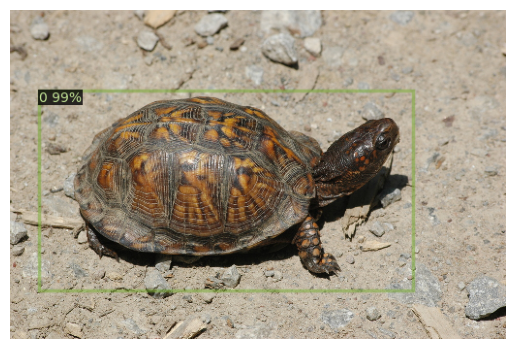

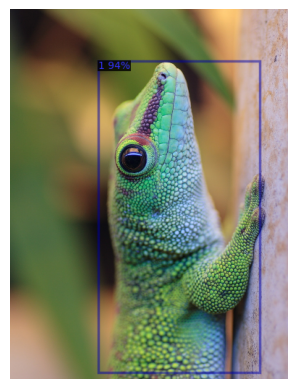

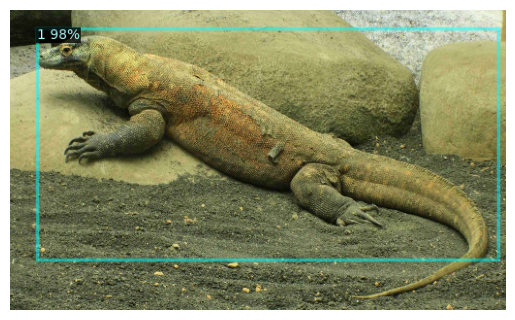

In [11]:
from detectron2.utils.visualizer import ColorMode
import random
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
dataset_dicts = get_dataset_dicts("dataset/fiftyone/open-images-v7/validation/")
turnliz_metadataval = MetadataCatalog.get("turnliz_validation")
for d in random.sample(dataset_dicts, 10):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=turnliz_metadataval,
                   scale=0.5,
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    #cv2_imshow(out.get_image()[:, :, ::-1])
    im = cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct colors
    plt.imshow(im)
    plt.axis("off")  # Hide axes
    plt.show()

In [12]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("turnliz_validation", ("bbox",), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "turnliz_validation")
print(inference_on_dataset(trainer.model, val_loader, evaluator))

[06/02 11:23:10 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[06/02 11:23:10 d2.evaluation.coco_evaluation]: Trying to convert 'turnliz_validation' to COCO format ...
[06/02 11:23:10 d2.data.datasets.coco]: Converting annotations of dataset 'turnliz_validation' to COCO format ...)
[06/02 11:23:11 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[06/02 11:23:11 d2.data.datasets.coco]: Conversion finished, #images: 143, #annotations: 166
[06/02 11:23:11 d2.data.datasets.coco]: Caching COCO format annotations at './output/turnliz_validation_coco_format.json' ...
[06/02 11:23:12 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|  Tortoise  | 57           |   Lizard   | 109          |
|            |              |            |              |
|   total    | 166          |            |         

# Export the model to onnx

In [13]:
import torch
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.export import TracingAdapter
from detectron2.data import build_detection_test_loader
from detectron2 import model_zoo
import os
import onnx 
import cv2

# Step 1: Load the configuration and model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(my_yaml))
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.DEVICE = "cuda"
# revise to match our number of classes
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2


# Step 2: Create Pytorch Model
model = build_model(cfg)
DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)
model.eval()

# Step 3: Trace the model with appropriate inputs
#im can be any image of your training/validation dataset 
im = cv2.imread("dataset/fiftyone/open-images-v7/validation/data/0ebb1151fd4e8fe4.jpg")
im_torch = torch.as_tensor(im.astype("float32").transpose(2, 0, 1))
inputs = [{"image": im_torch}]

traceable_model = TracingAdapter(model, inputs, None)

# Step 4: Export to ONNX with appropriate dynamic axes
torch.onnx.export(traceable_model, (im_torch,), 
                  "model.onnx", 
                  opset_version=16,
                  input_names = ['image'],
                  output_names = ['instances'],
                  dynamic_axes={'image' : {1 : 'height', 2: 'width'},
                                'instances' : {0 : 'batch_size'}}
                                )

[06/02 11:23:22 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/home/z890/Documents/ml_sample/detection/d2_FasterRCNN/detectron2/detectron2/structures/image_list.py:86: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert t.shape[:-2] == tensors[0].shape[:-2], t.shape
/home/z890/Documents/ml_sample/detection/d2_FasterRCNN/detectron2/detectron2/structures/boxes.py:151: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if tensor.numel() == 0:
/home/z890/Documents/ml_sample/detection/d2_FasterRCNN/detectron2/detectron2/structures/boxes.py:155: TracerWarning: Converting a tensor to a Python boolean might cause the trace t

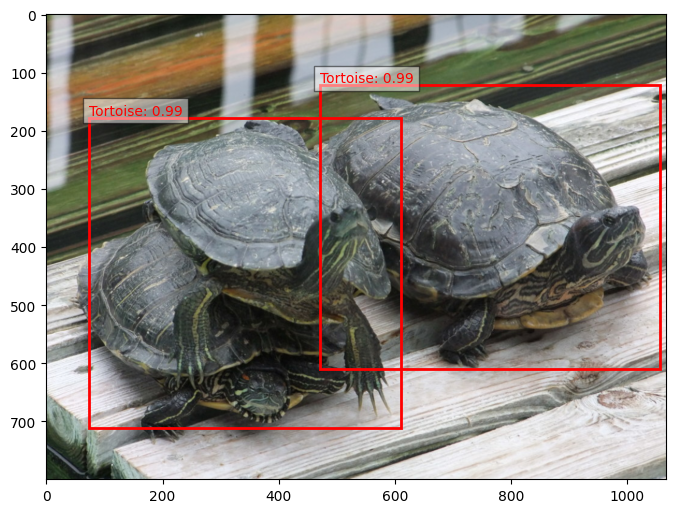

In [14]:
# try our onnx
import cv2
import onnxruntime as ort
import numpy as np
import matplotlib.pyplot as plt
from detectron2.data.transforms import ResizeTransform

# resize the image, min_size=800, max_size=1333 is the default setting
def resize(im, min_size=800, max_size=1333):
    h, w = im.shape[:2]
    scale = min_size / min(h, w)
    if max(h, w) * scale > max_size:
        scale = max_size / max(h, w)
    new_w = int(w * scale + 0.5)
    new_h = int(h * scale + 0.5)
    return cv2.resize(im, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

# Create an ONNX Runtime session
session = ort.InferenceSession("model.onnx")

im = cv2.imread("dataset/fiftyone/open-images-v7/validation/data/8201cac18b3e815f.jpg")
im = resize(im)

# Run inference
outputs = session.run(None, {"image": im.astype("float32").transpose(2, 0, 1)})
boxes, classes, scores, size = outputs

# Set score threshold
minimum_score = 0.7

# Filter valid detections
valid_detections = scores > minimum_score
valid_boxes = boxes[valid_detections]
valid_classes = classes[valid_detections]
valid_scores = scores[valid_detections]

# Plot image
plt.figure(figsize=(8, 8))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)
ax = plt.gca()

class_name = ["Tortoise", "Lizard"]
# Draw bounding boxes with labels
for box, cls, score in zip(valid_boxes, valid_classes, valid_scores):
    x1, y1, x2, y2 = box
    rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor="r", facecolor="none")
    ax.add_patch(rect)
    ax.text(x1, y1 - 5, f"{class_name[cls]}: {score:.2f}", color="red", fontsize=10, bbox=dict(facecolor="white", alpha=0.5))

plt.show()


In [15]:
# save predictions to json
from detectron2.engine import DefaultPredictor
from detectron2.data import build_detection_test_loader
import os
import json
import cv2
import numpy as np

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.01
output_dir = cfg.OUTPUT_DIR
os.makedirs(output_dir, exist_ok=True)

# Create predictor
predictor = DefaultPredictor(cfg)

# Function to convert detectron2 outputs to JSON serializable format
def convert_outputs_to_list(outputs, image_info):
    """
    Convert detectron2 outputs to a list of detections in JSON serializable format
    Each detection is a separate dictionary in the list
    """
    instances = outputs["instances"].to("cpu")
    predictions = []
    
    # Use file basename as image_id if not provided
    if "image_id" not in image_info:
        # Extract filename without extension as image_id
        file_name = image_info["file_name"]
        base_name = os.path.splitext(os.path.basename(file_name))[0]
        image_id = base_name
    else:
        image_id = image_info["image_id"]
    
    # Extract relevant information
    if len(instances) > 0:
        boxes = instances.pred_boxes.tensor.numpy() if instances.has("pred_boxes") else []
        scores = instances.scores.numpy() if instances.has("scores") else []
        classes = instances.pred_classes.numpy() if instances.has("pred_classes") else []
        
        for i in range(len(boxes)):
            # Convert box from [x1, y1, x2, y2] to [x, y, width, height]
            box = boxes[i]
            bbox = [float(box[0]), float(box[1]), 
                    float(box[2] - box[0]), float(box[3] - box[1])]
            
            prediction = {
                "image_id": image_id,
                "category_id": int(classes[i]),
                "bbox": bbox,  # [x, y, width, height] format
                "score": float(scores[i])
            }
            predictions.append(prediction)
    
    return predictions

# Save predictions as JSON files
def save_predictions_json(dataset_dicts, predictor, output_dir):
    """
    Run detection on each image in dataset_dicts and save predictions as JSON
    """
    all_predictions = []
    
    for i, d in enumerate(dataset_dicts):
        try:
            img = cv2.imread(d["file_name"])
            if img is None:
                print(f"Warning: Could not read image {d['file_name']}")
                continue
                
            outputs = predictor(img)
            
            # Convert outputs to list format
            predictions = convert_outputs_to_list(outputs, d)
            
            # Add to combined list
            all_predictions.extend(predictions)
                            
        except Exception as e:
            print(f"Error processing image {d.get('file_name', i)}: {e}")
    
    # Save all predictions in a single file
    with open(os.path.join(output_dir, "detections.json"), "w") as f:
        json.dump(all_predictions, f, indent=2)
    
    print(f"Saved predictions to {os.path.join(output_dir, 'detections.json')}")

# Run inference and save predictions
save_predictions_json(dataset_dicts, predictor, output_dir)

[06/02 11:23:43 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
Saved predictions to ./output/detections.json


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


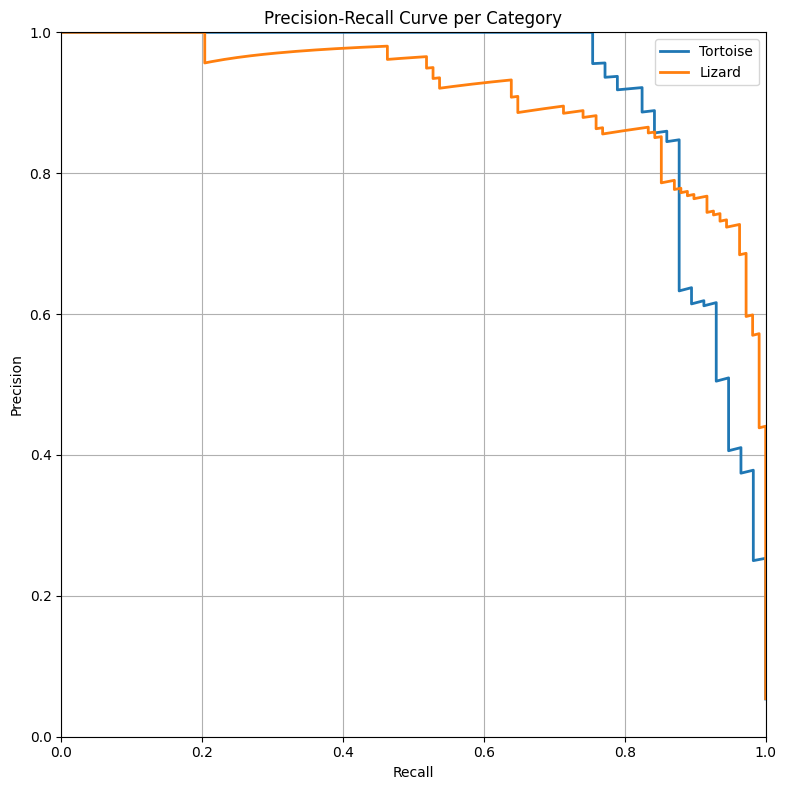

In [16]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from collections import defaultdict
from sklearn.metrics import precision_recall_curve

truth_json = 'output/turnliz_validation_coco_format.json'
pred_json = 'output/detections.json'
# Load COCO GT and prediction JSONs
coco_gt = COCO(truth_json)
with open(pred_json, 'r') as f:
    predictions = json.load(f)

# Get category ID to name mapping
categories = coco_gt.loadCats(coco_gt.getCatIds())
cat_id_to_name = {cat['id']: cat['name'] for cat in categories}
cat_ids = list(cat_id_to_name.keys())

# Group predictions by category
preds_by_cat = defaultdict(list)
for pred in predictions:
    preds_by_cat[pred['category_id']].append(pred)

# Group GT annotations by category
gt_by_cat = defaultdict(list)
for ann in coco_gt.dataset['annotations']:
    gt_by_cat[ann['category_id']].append(ann)

def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    return interArea / (boxAArea + boxBArea - interArea + 1e-6)

iou_threshold = 0.5
class_curves = {}

for cat_id in cat_ids:
    cat_id = cat_id
    y_true = []
    y_scores = []

    preds = sorted(preds_by_cat[cat_id], key=lambda x: -x['score'])
    gt_annots = gt_by_cat[cat_id]
    used = set()

    for pred in preds:
        pred_box = pred['bbox']
        image_id = pred['image_id']
        matched = False

        for gt in gt_annots:
            if gt['image_id'] != image_id or gt['id'] in used:
                continue
            iou = compute_iou(pred_box, gt['bbox'])
            if iou >= iou_threshold:
                matched = True
                used.add(gt['id'])
                break

        y_true.append(1 if matched else 0)
        y_scores.append(pred['score'])

    if len(set(y_true)) < 2:
        if sum(y_true) == 0:
            print(f"Class {cat_id_to_name[cat_id]} has ALL FALSE POSITIVES (no TP).")
        else:
            print(f"Class {cat_id_to_name[cat_id]} has ALL TRUE POSITIVES (no FP).")
        continue

    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    class_curves[cat_id] = {
        'precision': precision,
        'recall': recall
    }

# Plotting Precision-Recall curves
plt.figure(figsize=(10, 8))
for cat_id, data in class_curves.items():
    plt.plot(data['recall'], data['precision'], label=cat_id_to_name[cat_id], linewidth=2)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve per Category')
plt.grid(True)
plt.legend()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
#plt.savefig('precision_recall_curves.png', bbox_inches='tight', dpi=300)
plt.show()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


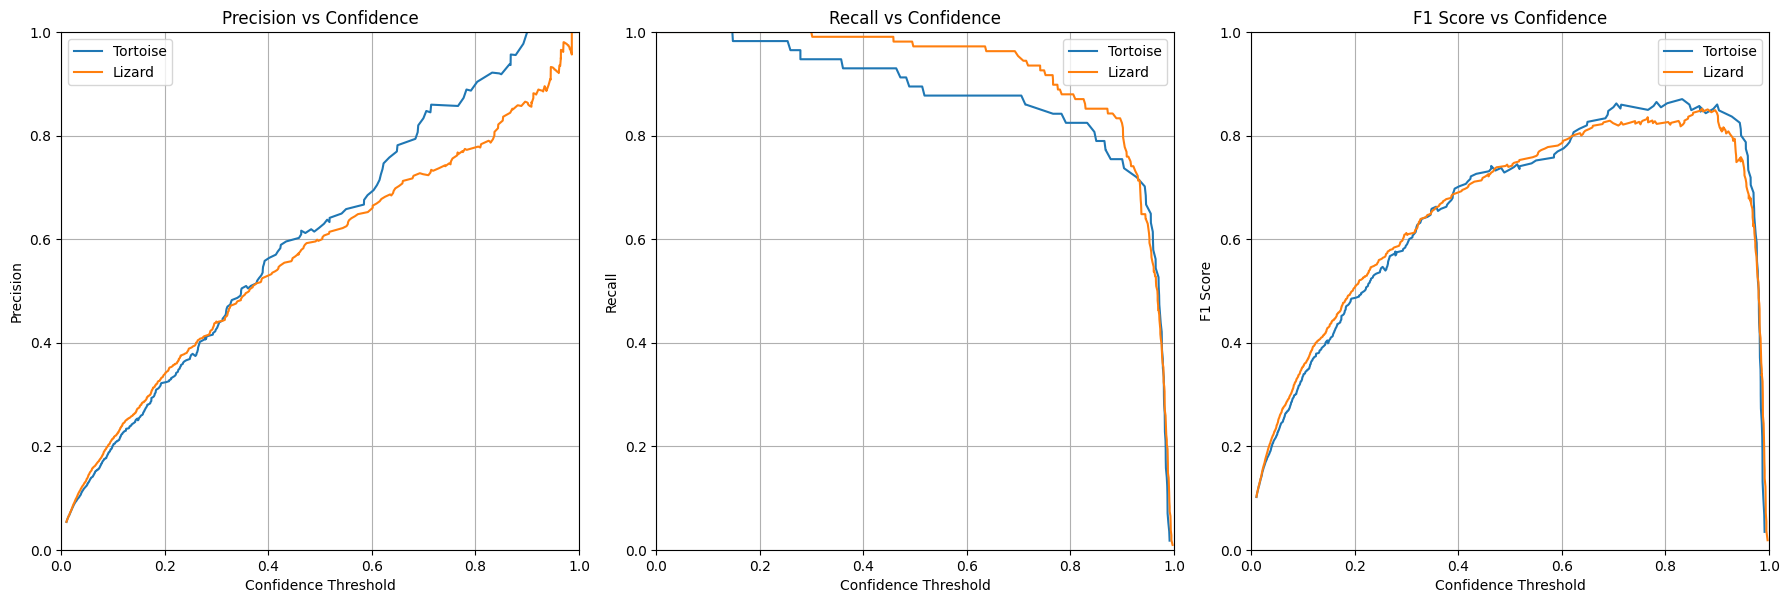

In [17]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from collections import defaultdict
from sklearn.metrics import precision_recall_curve

# Load annotations and predictions
truth_json = 'output/turnliz_validation_coco_format.json'
pred_json = 'output/detections.json'

# Load COCO GT and prediction JSONs
coco_gt = COCO(truth_json)
with open(pred_json, 'r') as f:
    predictions = json.load(f)

# Get category ID to name mapping
categories = coco_gt.loadCats(coco_gt.getCatIds())
cat_id_to_name = {cat['id']: cat['name'] for cat in categories}
cat_ids = list(cat_id_to_name.keys())

# Group predictions by category
preds_by_cat = defaultdict(list)
for pred in predictions:
    preds_by_cat[pred['category_id']].append(pred)

# Group GT annotations by category
gt_by_cat = defaultdict(list)
for ann in coco_gt.dataset['annotations']:
    gt_by_cat[ann['category_id']].append(ann)

def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    return interArea / (boxAArea + boxBArea - interArea + 1e-6)

iou_threshold = 0.5
class_curves = {}

for cat_id in cat_ids:
    y_true = []
    y_scores = []

    preds = sorted(preds_by_cat[cat_id], key=lambda x: -x['score'])
    gt_annots = gt_by_cat[cat_id]
    used = set()

    for pred in preds:
        pred_box = pred['bbox']
        image_id = pred['image_id']
        matched = False

        for gt in gt_annots:
            if gt['image_id'] != image_id or gt['id'] in used:
                continue
            iou = compute_iou(pred_box, gt['bbox'])
            if iou >= iou_threshold:
                matched = True
                used.add(gt['id'])
                break

        y_true.append(1 if matched else 0)
        y_scores.append(pred['score'])

    if len(set(y_true)) < 2:
        if sum(y_true) == 0:
            print(f"Class {cat_id_to_name[cat_id]} has ALL FALSE POSITIVES (no TP).")
        else:
            print(f"Class {cat_id_to_name[cat_id]} has ALL TRUE POSITIVES (no FP).")
        continue

    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    class_curves[cat_id] = {
        'precision': precision,
        'recall': recall,
        'thresholds': thresholds
    }

# Plotting
plt.figure(figsize=(18, 6))

# 1. Precision-Confidence
plt.subplot(1, 3, 1)
for cat_id, data in class_curves.items():
    plt.plot(data['thresholds'], data['precision'][:-1], 
             label=cat_id_to_name[cat_id])
plt.xlabel('Confidence Threshold')
plt.ylabel('Precision')
plt.title('Precision vs Confidence')
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()

# 2. Recall-Confidence
plt.subplot(1, 3, 2)
for cat_id, data in class_curves.items():
    plt.plot(data['thresholds'], data['recall'][:-1], 
             label=cat_id_to_name[cat_id])
plt.xlabel('Confidence Threshold')
plt.ylabel('Recall')
plt.title('Recall vs Confidence')
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()

# 3. NEW: F1-Confidence
plt.subplot(1, 3, 3)
for cat_id, data in class_curves.items():
    # Calculate F1 scores
    precision = data['precision'][:-1]
    recall = data['recall'][:-1]
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
    
    plt.plot(data['thresholds'], f1_scores, 
             label=cat_id_to_name[cat_id])

plt.xlabel('Confidence Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Confidence')
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.tight_layout()
#plt.savefig('precision_recall_f1_confidence.png', bbox_inches='tight', dpi=300)
plt.show()


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!


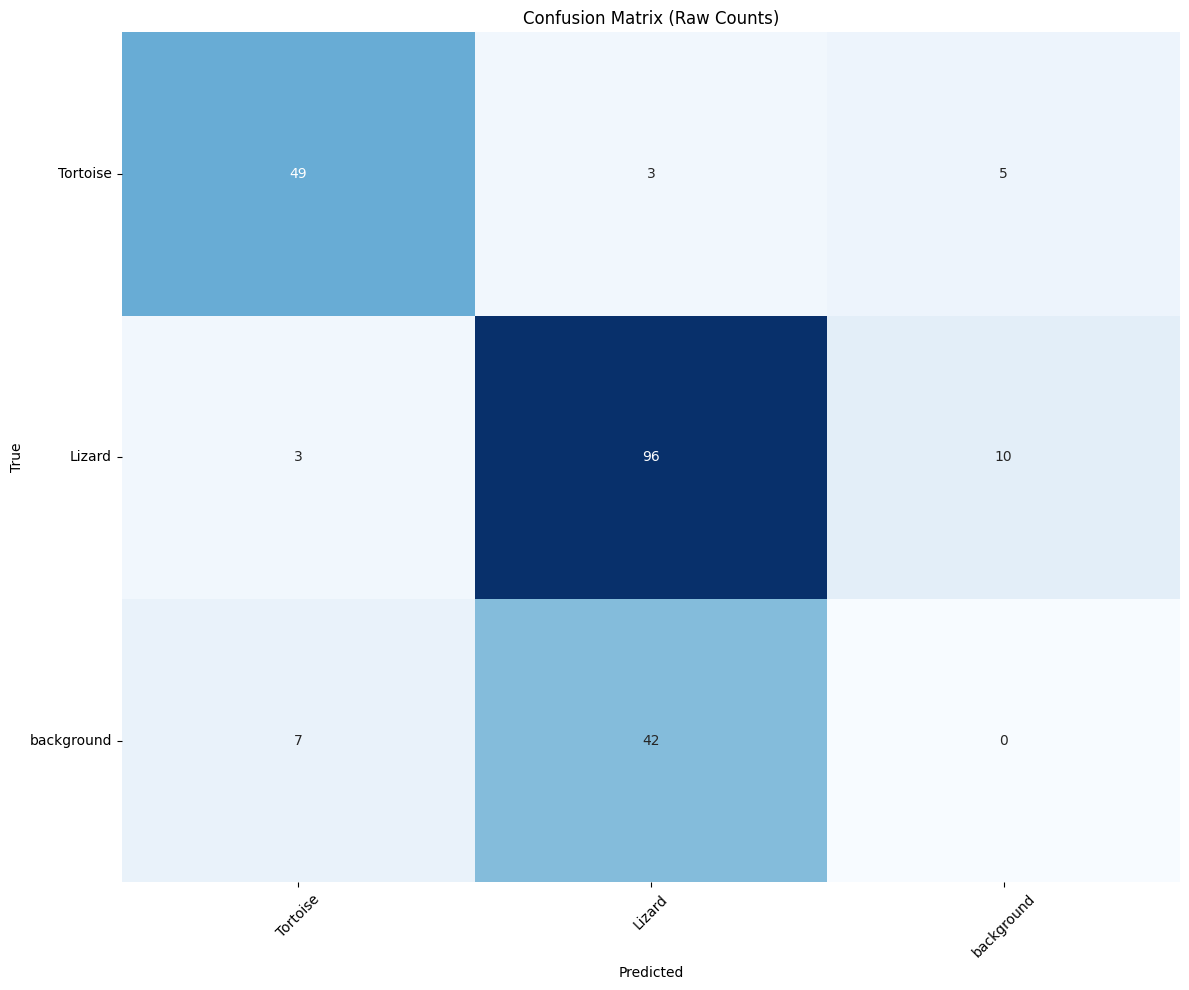

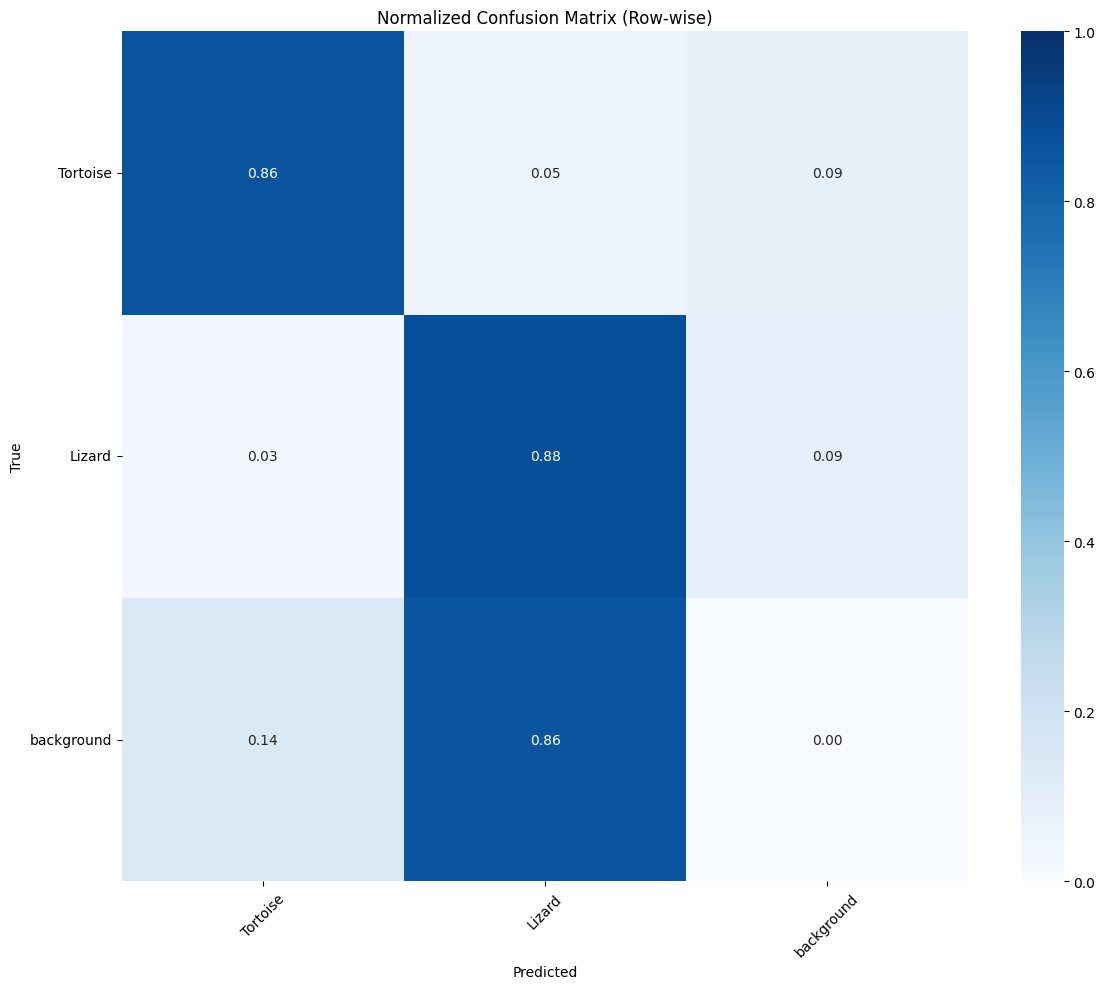

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pycocotools import mask as maskUtils
import json
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from sklearn.metrics import confusion_matrix
from collections import defaultdict

# Load ground truth and predictions
truth_json = 'output/turnliz_validation_coco_format.json'
pred_json = 'output/detections.json'

# Load COCO API for ground truth
coco_gt = COCO(truth_json)

# Load the original predictions
with open(pred_json) as f:
    pred_data = json.load(f)
    
# filter out low confidence
threshold = 0.7
filtered_data = [pred_data_t for pred_data_t in pred_data if pred_data_t['score']>=threshold]
coco_dt = coco_gt.loadRes(filtered_data)

class_names = [coco_gt.loadCats(ids)[0]['name'] for ids in coco_gt.getCatIds()]
num_classes = len(class_names)

def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    return interArea / (boxAArea + boxBArea - interArea + 1e-6)

def compute_confusion_matrix(coco_gt, coco_dt, iou_thresh=0.65):
    """
    Compute confusion matrix with IoU matching
    Returns: (raw_confusion_matrix, normalized_confusion_matrix)
    """
    num_classes = len(coco_gt.getCatIds())
    cm = np.zeros((num_classes+1, num_classes+1), dtype=int)  # +1 for background/FP
    
    for img_id in coco_gt.getImgIds():
        gt_anns = coco_gt.loadAnns(coco_gt.getAnnIds(imgIds=img_id))
        dt_anns = coco_dt.loadAnns(coco_dt.getAnnIds(imgIds=img_id))

        # Track which GT boxes have been matched
        matched_gt = [False] * len(gt_anns)
        
        # Process detections sorted by confidence (highest first)
        dt_anns = sorted(dt_anns, key=lambda x: -x['score'])
        
        for dt in dt_anns:
            best_iou = iou_thresh
            best_idx = -1
            
            # Find best matching GT
            for i, gt in enumerate(gt_anns):
                if not matched_gt[i]:
                    iou = compute_iou(dt['bbox'], gt['bbox'])
                    if iou > best_iou:
                        best_iou = iou
                        best_idx = i
            
            if best_idx >= 0:  # True positive (of at least there is object, despite of classes)
                matched_gt[best_idx] = True
                gt_class = gt_anns[best_idx]['category_id']  
                dt_class = dt['category_id']   
                cm[gt_class, dt_class] += 1
            else:  # False positive
                dt_class = dt['category_id'] 
                cm[-1, dt_class] += 1  # Last row is for FP
        
        # Any unmatched GT are false negatives
        for i, matched in enumerate(matched_gt):
            if not matched:
                gt_class = gt_anns[i]['category_id'] 
                cm[gt_class, -1] += 1  # Last column is for FN
    
    # Normalized version (row-wise)
    cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-6)
    
    return cm, cm_norm

# Compute matrices
cm_raw, cm_norm = compute_confusion_matrix(coco_gt, coco_dt)
class_names_with_bg = class_names + ['background']
# Plot raw confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_raw, annot=True, fmt='d', 
            xticklabels=class_names_with_bg, yticklabels=class_names_with_bg,
            cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Raw Counts)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
#plt.savefig('confusion_matrix_raw.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot normalized confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_norm, annot=True, fmt='.2f', 
            xticklabels=class_names_with_bg, yticklabels=class_names_with_bg,
            cmap='Blues', vmin=0, vmax=1)
plt.title('Normalized Confusion Matrix (Row-wise)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
#plt.savefig('confusion_matrix_normalized.png', dpi=300, bbox_inches='tight')
plt.show()
